In [49]:
import cv2
from matplotlib import pyplot as plt

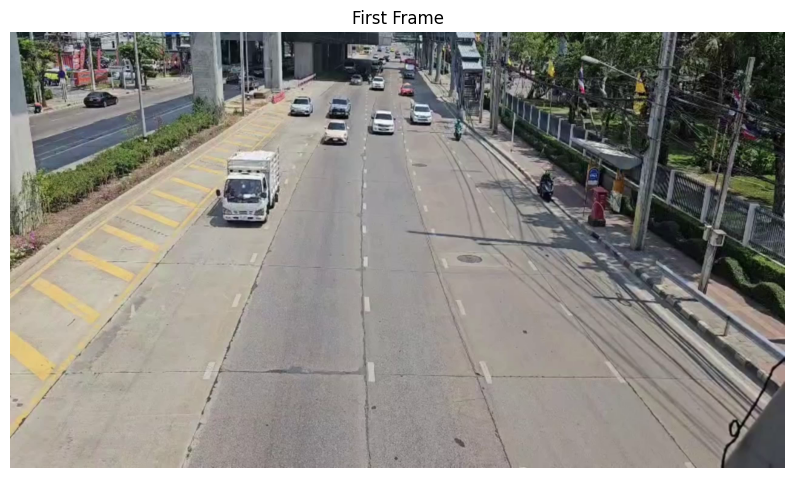

In [50]:
cap = cv2.VideoCapture('../input_videos/short_input_video.mp4')

# Check if video opened successfully
if not cap.isOpened():
  print("Error: Could not open video file.")
else:
  # Read the first frame
  ret, first_frame = cap.read()
  if ret:
    # Convert BGR to RGB for matplotlib
    first_frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
    # Display the first frame
    plt.figure(figsize=(10, 8))
    plt.imshow(first_frame_rgb)
    plt.title('First Frame')
    plt.axis('off')
    plt.show()
  else:
    print("Error: Could not read first frame.")

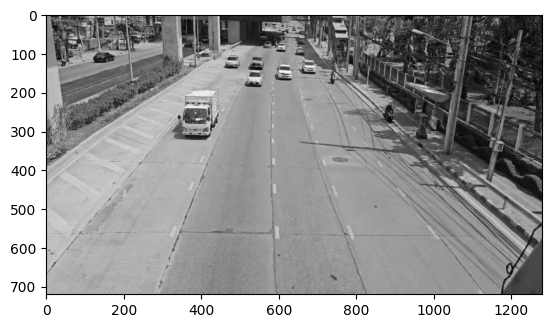

In [51]:
gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (1, 1), 0)
plt.imshow(gray, cmap='gray')

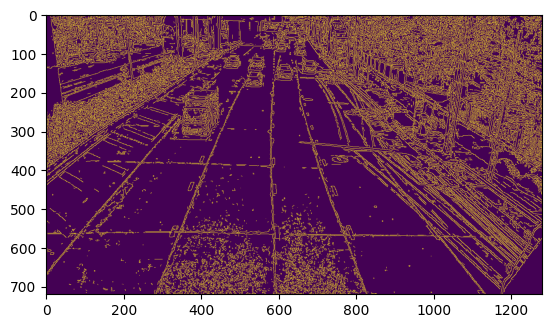

In [52]:
edges = cv2.Canny(gray, 50, 70)
plt.imshow(edges)

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

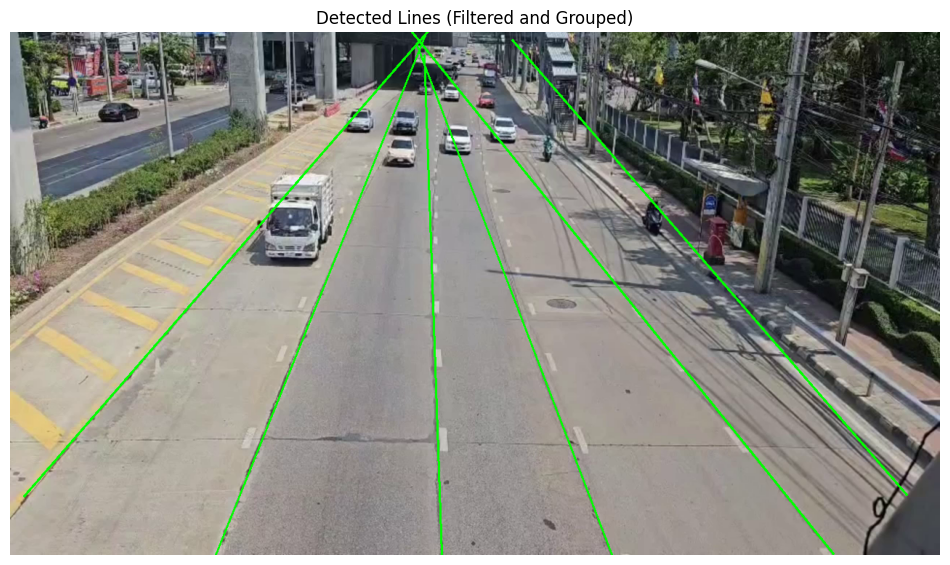

In [53]:
import numpy as np


# Create a copy of the frame to draw lines on
frame_with_lines = first_frame.copy()

# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=5, maxLineGap=250)

# Filter and draw only the lines we want
if lines is not None:
  # Group similar lines together
  grouped_lines = []
  for line in lines:
    x1, y1, x2, y2 = line[0]
    
    # Calculate the angle of the line
    if x2 != x1:  # Avoid division by zero
      angle = np.degrees(np.arctan((y2-y1)/(x2-x1)))
    else:
      angle = 90  # Vertical line
    
    # Filter out near-horizontal lines (likely horizon lines)
    # Keep lines that have a significant angle (e.g. greater than 50 degrees)
    if abs(angle) > 45:
      # Check if this line is similar to any existing group
      found_group = False
      for group in grouped_lines:
        group_x1, group_y1, group_x2, group_y2 = group[0]
        group_angle = np.degrees(np.arctan((group_y2-group_y1)/(group_x2-group_x1))) if group_x2 != group_x1 else 90
        
        # If angles are similar and lines are close, add to group
        if abs(angle - group_angle) < 15 and np.sqrt((x1-group_x1)**2 + (y1-group_y1)**2) < 100:
          # We could average the lines here, but for now just keep track of the group
          group.append(line[0])
          found_group = True
          break
      
      if not found_group:
        grouped_lines.append([line[0]])
  
  # Draw the representative line for each group (using the first line in each group)
  for group in grouped_lines:
    # For simplicity, just use the first line in each group
    x1, y1, x2, y2 = group[0]
    cv2.line(frame_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
else:
  print("No lines detected")
  
# Display the result
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines (Filtered and Grouped)')
plt.axis('off')

In [54]:
grouped_lines



[[array([ 19, 639, 575,   0], dtype=int32),
  array([ 14, 649, 577,   1], dtype=int32),
  array([ 19, 641, 576,   0], dtype=int32)],
 [array([ 553,    1, 1133,  718], dtype=int32),
  array([ 567,   17, 1111,  688], dtype=int32),
  array([ 551,    3, 1131,  719], dtype=int32)],
 [array([283, 719, 573,   1], dtype=int32),
  array([280, 718, 570,   0], dtype=int32)],
 [array([559,  17, 828, 719], dtype=int32),
  array([551,   1, 826, 719], dtype=int32)],
 [array([570,  33, 594, 719], dtype=int32)],
 [array([ 691,   12, 1234,  637], dtype=int32)]]

Lines sorted from left to right:
Group 1: Start (19, 639), End (575, 0), Angle: -48.97°, Lines in group: 3
Group 2: Start (283, 719), End (573, 1), Angle: -68.01°, Lines in group: 2
Group 3: Start (553, 1), End (1133, 718), Angle: 51.03°, Lines in group: 3
Group 4: Start (559, 17), End (828, 719), Angle: 69.03°, Lines in group: 2
Group 5: Start (570, 33), End (594, 719), Angle: 88.00°, Lines in group: 1
Group 6: Start (691, 12), End (1234, 637), Angle: 49.02°, Lines in group: 1


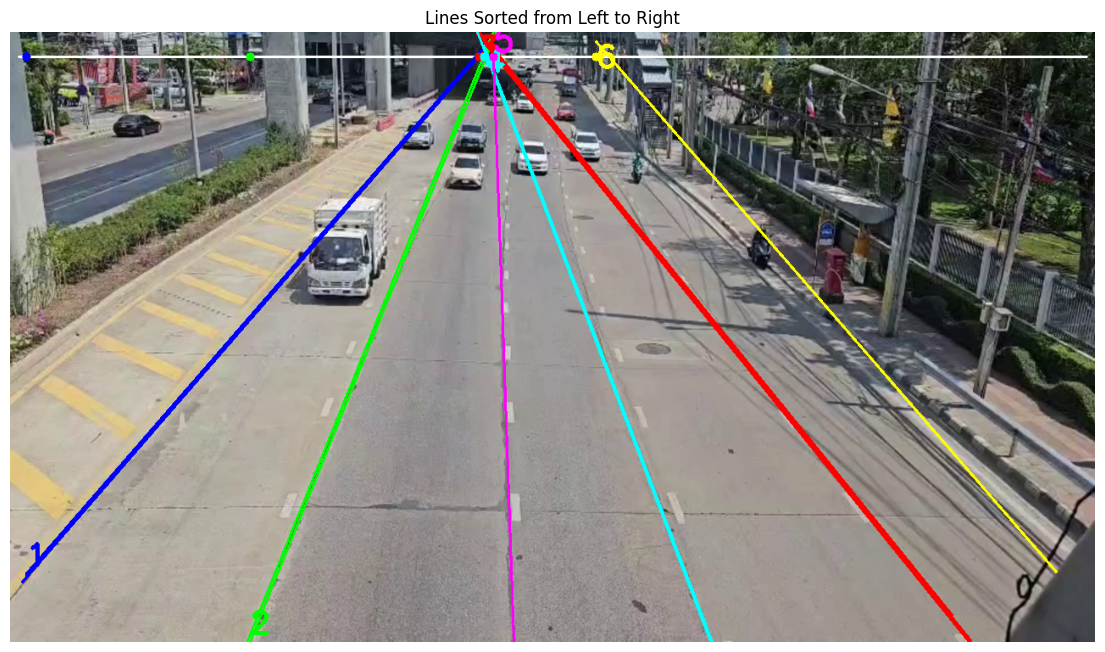

In [55]:
# Sort grouped lines by starting x-position (using the first line in each group)
sorted_grouped_lines = sorted(grouped_lines, key=lambda group: group[0][0])  # Sort by x1 of first line in group

# Display information about sorted groups
print("Lines sorted from left to right:")
for i, group in enumerate(sorted_grouped_lines):
  group_line = group[0]  # First line in group
  x1, y1, x2, y2 = group_line
  
  # Calculate angle
  if x2 != x1:  # Avoid division by zero
    angle = np.degrees(np.arctan((y2-y1)/(x2-x1)))
  else:
    angle = 90  # Vertical line
    
  print(f"Group {i+1}: Start ({x1}, {y1}), End ({x2}, {y2}), Angle: {angle:.2f}°, Lines in group: {len(group)}")

# Visualize the sorted groups with different colors
colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255), 
      (128,0,0), (0,128,0), (0,0,128), (128,128,0)]
sorted_lines_img = first_frame.copy()

# Draw a horizontal reference line to show left-to-right ordering
cv2.line(sorted_lines_img, (10, 30), (first_frame.shape[1]-10, 30), (255, 255, 255), 2)

for i, group in enumerate(sorted_grouped_lines):
  color = colors[i % len(colors)]  # Cycle through colors
  for line in group:
    x1, y1, x2, y2 = line
    cv2.line(sorted_lines_img, (x1, y1), (x2, y2), color, 2)
  
  # Add label for each group showing its position in left-to-right order
  label_x = group[0][0]
  label_y = group[0][1] - 10 if group[0][1] > 20 else group[0][1] + 30
  cv2.putText(sorted_lines_img, f"{i+1}", (label_x, label_y), 
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
  
  # Mark the starting point on the reference line
  cv2.circle(sorted_lines_img, (label_x, 30), 5, color, -1)

# Display the image with sorted lines
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(sorted_lines_img, cv2.COLOR_BGR2RGB))
plt.title('Lines Sorted from Left to Right')
plt.axis('off')
plt.show()